In [2]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

from subprocess import call
from networkit import *

In [3]:
data = {}

for path in glob.glob(os.path.expanduser("/amd.home/home/i11/zeitz/ma/data/results/paper/weak_scaling/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [4]:
algo_name_mapping = {
    'synchronous local moving with map equation': 'Distr. MapEq',
    'synchronous local moving with modularity': 'Distr. Modularity'
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: ' w. Seq.', np.NaN: '' })

In [6]:
def siml(x):
    files = sorted(glob.glob(os.path.expanduser("/algoDaten/zeitz/graphs/LFR/part" + x['graph'][33:])))
    call("rm tmp", shell=True)
    call("cat {} > tmp".format(' '.join(files)), shell=True)
    ground_truth = community.BinaryEdgeListPartitionReader(0, 4).read('tmp')
    call("rm tmp", shell=True)
    
    files = sorted(glob.glob(os.path.expanduser('/amd.home/home/i11/zeitz/ma/data/results/paper/weak_scaling/' + x['path'].replace('@@@@-#####', '*'))))
    call("rm tmp", shell=True)
    call("cat {} > tmp".format(' '.join(files)), shell=True)
    clustering = community.BinaryEdgeListPartitionReader(0, 4).read('tmp')
    call("rm tmp", shell=True)
        
    g = graph.Graph(ground_truth.numberOfElements())
    nmi = 1.0 - community.NMIDistance().getDissimilarity(g, clustering, ground_truth)
    ari = 1.0 - community.AdjustedRandMeasure().getDissimilarity(g, clustering, ground_truth)
    return pd.Series([nmi, ari, clustering.numberOfSubsets()])
    
frames['clustering'][['NMI', 'ARI', 'cluster_count']] = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .apply(siml, axis=1)

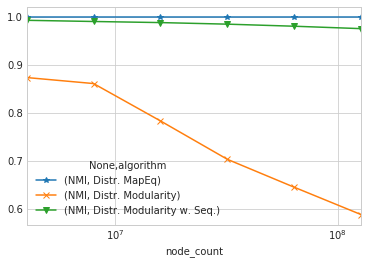

In [17]:
frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['node_count', 'algorithm'])['NMI'].mean().to_frame().unstack().plot(logx=True, style=['-*', '-x', '-v'])

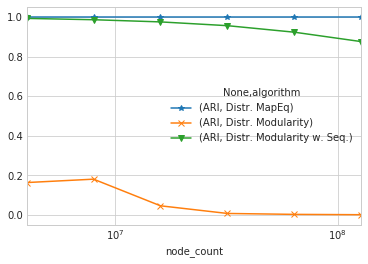

In [18]:
frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['node_count', 'algorithm'])['ARI'].mean().to_frame().unstack().plot(logx=True, style=['-*', '-x', '-v'])